Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import logging
from itertools import combinations
from itertools import accumulate
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
from pyvis.network import Network
from matplotlib import pyplot as plt

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [2]:
CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
# It return r-length tuples in sorted order with no repeated elements 
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Isangel,-19.53,169.28
1,Lakatoro,-16.09,167.40
2,Longana,-15.30,168.00
3,Luganville,-15.51,167.15
4,Norsup,-16.07,167.39


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [3]:
def tsp_cost(tsp):
    #assert -> se la condizione torna true tutto ok, altrimenti lancia un errore
    #check che il primo e l'ultimo elemento siano uguali
    assert tsp[0] == tsp[-1]
    #check che tutte le città siano presenti e che non ci siano duplicati
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## First Greedy Algorithm

Questo algoritmo greedy permette di trovare una prima soluzione al problema (era quello che mi era venuto in mente, ma l'ha già fatto lui)

In [4]:
visited = np.full(4, False)
dist = DIST_MATRIX.copy()
dist = dist[:4, :4]
dist

visited[1] = True
visited[3] = True

d = dist[:, ~visited]
closest = np.argmin(d[0])
d


array([[  0.        , 487.49450912],
       [429.73058655, 108.52881838],
       [487.49450912,   0.        ],
       [499.07812514,  94.15587872]])

In [5]:
# visited = np.full(len(CITIES), False)
# dist = DIST_MATRIX.copy()
# city = 0
# visited[city] = True
# #tsp per come è stato implementato è una lista di interi
# tsp = list()
# tsp.append(int(city))
# while not np.all(visited):
#     dist[:, city] = np.inf
#     #ritorna l'indice della città più vicina
#     closest = np.argmin(dist[city])
#     logging.debug(
#         f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
#     )
#     visited[closest] = True
#     city = closest
#     tsp.append(int(city))
# logging.debug(
#     f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
# )
# tsp.append(tsp[0])


# logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")


## Greedy solution: 2-opt algorithm

### Idea

We check if there are two edges that can be swapped to reduce the total length of the tour. If we find such a pair, we swap them and repeat the process until no more improvements are made.

In [6]:
#non funziona
def SwapEdges(tsp, id1, id2):
    newTsp = tsp.copy()
    #check if swapping two edges in the tsp improves the cost
    
    newTsp[id1+1:id2] = newTsp[id1+1:id2][::-1]
            
    return newTsp    

In [7]:
#non funziona
def UncrossEdges(tsp):
    newTsp = tsp.copy()
    #check if swapping two edges in the tsp improves the cost
    #this random part has to be changed -> enumerate all the possible combinations of edges
    for i in range(100):
        for id1, id2 in combinations(range(len(tsp)-2), 2):
            A = newTsp[id1]
            B = newTsp[id1+1]
            C = newTsp[id2]
            D = newTsp[id2+1]
            
            #if city1-city2 + city3-city4 is less than city1-city3 + city2-city4, swap the two edges
            if((DIST_MATRIX[A,B]+DIST_MATRIX[C,D]) > (DIST_MATRIX[A,C]+DIST_MATRIX[B,D])):
                #if it does, swap the entire path among the two cities
                newTsp[id1+1:id2] = newTsp[id1+1:id2][::-1]
                print("Uncrossing edges: ", CITIES.at[A,'name'],"-",CITIES.at[B,'name']," and ",CITIES.at[C,'name'],"-",CITIES.at[D,'name'])

    return newTsp    

In [8]:
def printEdge(city, closest):
    logging.debug(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
    )

In [9]:
def greedyFirstSolution(canStartFrom):
    
    if np.all(canStartFrom == False):
        canStartFrom = np.full(len(CITIES), True)
        
    city = np.random.choice(np.where(canStartFrom)[0])
    #print(city)
    canStartFrom[city] = False

    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    #city = np.random.randint(len(CITIES))
    visited[city] = True
    
    #tsp per come è stato implementato è una lista di interi
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        #ritorna l'indice della città più vicina
        closest = np.argmin(dist[city])
        #printEdge(city, closest)
        visited[closest] = True
        city = closest
        tsp.append(int(city))
        #printEdge(tsp[-1], tsp[0])
    tsp.append(tsp[0])
    return tsp
    

In [10]:
stationary = 0

canStartFrom = np.full(len(CITIES), True)
tsp = greedyFirstSolution(canStartFrom)
cost = tsp_cost(tsp)
minDist = cost
history = list()

logging.info(f"First greedy result: Found a path of {len(tsp)-1} steps, total length {cost:.2f}km")

while stationary<5000:

    for i in range(0,len(CITIES)-1):
        for j in range (i+1,len(CITIES)):
            newTsp = SwapEdges(tsp, i, j)
            newDist = tsp_cost(newTsp)
            history.append(newDist)  
            if(newDist < minDist):
               minDist = newDist
               tsp = newTsp
               i=0
               j=i+1
               break
            else:
                stationary += 1      
    newTsp = greedyFirstSolution(canStartFrom)
   
logging.info(f"2-opt result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")

INFO:root:First greedy result: Found a path of 8 steps, total length 1486.38km
INFO:root:2-opt result: Found a path of 8 steps, total length 1357.99km


## Visualization

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\marti\\Desktop\\Poli\\Computational_Intelligence\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\marti\\Desktop\\Poli\\Computational_Intelligence\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager

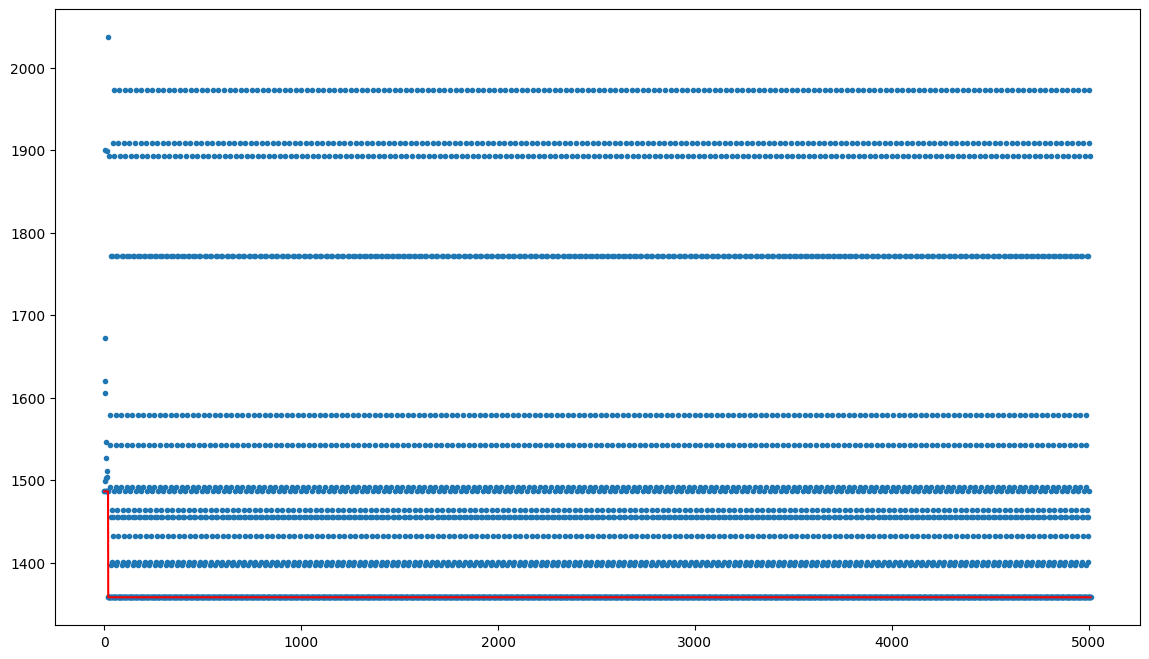

In [11]:
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

In [12]:
net = Network(notebook=True, 
              cdn_resources="remote",
              bgcolor="#222222",
              font_color="white",
              height="750px",
              width="100%",
              )
net.add_nodes(range(len(CITIES)), label=CITIES.name)

# for i in range (len(CITIES)-1):
#     for j in range (i+1, len(CITIES)):
#         if(i!=j):
#             net.add_edge(i, j, value=DIST_MATRIX[i,j], color='blue')

# idea: provo a fare un sotto grafo con gli edge rossi e controllo che l'edge non sia stato preso quando faccio il grafo completamente connesso
for i in range (len(tsp)-1):
    net.add_edge(tsp[i], tsp[i+1], value=DIST_MATRIX[tsp[i],tsp[i+1]], color='red')


    
net.show("tsp.html")



tsp.html
